# Geospatial ML - Further Analysis - Part III

The first tutorial was written originally by Thomas Ostersen and Tom Carmichael of [Datarock](https://datarock.com.au/) for Transform 2022 conference. I thank them for putting togther this tutorial and sharing it, under an open license. Please give all kudos to them :) 

### Orignal Repo

is [here](https://github.com/Solve-Geosolutions/transform_2022)

### Original Data License

All data presented in this tutorial were derived from open data sets made available through [Mineral Resources Tasmania](https://www.mrt.tas.gov.au/) and [Geoscience Australia](https://www.ga.gov.au/).

**LICENSE CONDITIONS**

By exporting this data you accept and comply with the terms and conditions set out below:

[Creative Commons Attribution 3.0 Australia](https://creativecommons.org/licenses/by/3.0/au/)

<img src="assets/creative_commons_logo.png" />

# Why This Mining Geology Example?

This is a great example of how we need to account for [spatial autocorrelation](https://www.paulamoraga.com/book-spatial/spatial-autocorrelation.html#) (another reference [here](https://mgimond.github.io/Spatial/spatial-autocorrelation.html)) for machine learning projects. Rocks generally (but not always!) are not time dependent. I would not necessairly use the same methods for time dependent weather/climate datasets. 

## Roadmap

  1. Load and inspect data sets
  1. Combine data sets to build a labeled N<sub>pixel</sub>, N<sub>layers</sub> array for model training
      - inspect differences between proximal vs. distal to mineralisation pixels      
  1. Train a random GBDT classificer     
  1. Develop a checkerboard data selection procedure, train and evaluate models
      - discuss effects of spatially separated testing data
  2. Grid Search for the classifier
  3. Recursive Feature importance


 
---

You might need to add these two packages to your enviroment:

In [1]:
!pip install rasterio

  Using cached rasterio-1.3.10-cp310-cp310-manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl.metadata (3.4 kB)
Using cached rasterio-1.3.10-cp310-cp310-manylinux2014_x86_64.whl (21.5 MB)
Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)


In [2]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)


In [3]:
# Import key packages
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler

In [4]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance


print('XGboost version', xgb.__version__ )

XGboost version 2.0.3


In [5]:
# set some plotting parameters 
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

## Pointing to our data directory

In [6]:
data_dir = 'geodata/'

# set path to minoccs
point_fn = os.path.join(data_dir, 'sn_w_minoccs.gpkg')

# make a list of rasters in the data directory
geotiffs = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if '.tif' in x]
point_fn, geotiffs

('geodata/sn_w_minoccs.gpkg',
 ['geodata/tasmag_TMI.tif',
  'geodata/tasrad_K_pct.tif',
  'geodata/tasrad_U_ppm.tif',
  'geodata/tasgrav_IR_1VD.tif',
  'geodata/tasmag_TMI_1VD.tif',
  'geodata/tasrad_Th_ppm.tif',
  'geodata/tasgrav_IR.tif'])

First cut at plotting, where do we have occurances

<Axes: >

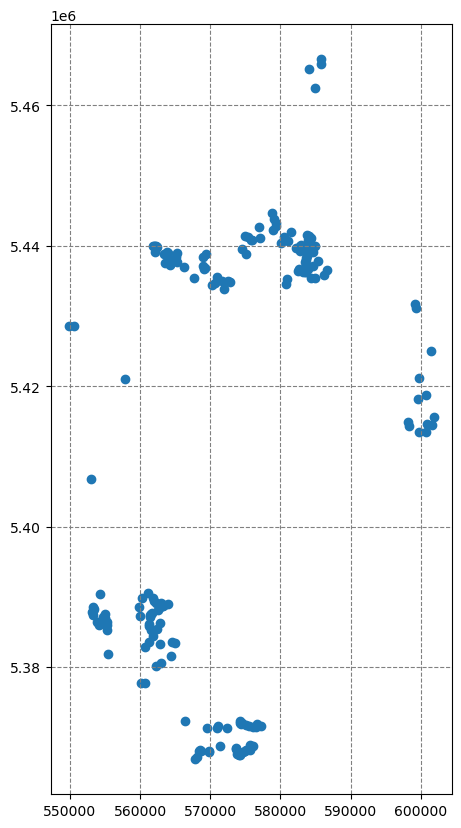

In [7]:
df = gpd.read_file(point_fn)
df.plot()

### Reading in GeoTiffs

In [8]:
# read geotiffs
data, names = [], []  # Lists to store data and corresponding file names
for fn in geotiffs:  # Loop through each GeoTIFF file
    with rasterio.open(fn, 'r') as src:  # Open GeoTIFF file for reading
        # read spatial information
        transform = src.transform  # Get affine transformation matrix
        region = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])  # Get bounding box coordinates (left, bottom, right, top)
        # read band 1 data
        d = src.read(1)  # Read data from the first band
        nodata_mask = d == src.nodata  # Create a mask for NoData values
        d[nodata_mask] = np.nan  # Replace NoData values with NaN
        # append data to lists
        data.append(d)  # Append data to the list
        names.append(os.path.basename(fn).replace('.tif',''))  # Append file name to the list (without extension)

# stack list into 3D numpy array
data = np.stack(data)  # Stack the list of arrays into a 3D numpy array
data.shape, names  # Return the shape of the data array and the list of file names

((7, 2633, 1876),
 ['tasmag_TMI',
  'tasrad_K_pct',
  'tasrad_U_ppm',
  'tasgrav_IR_1VD',
  'tasmag_TMI_1VD',
  'tasrad_Th_ppm',
  'tasgrav_IR'])

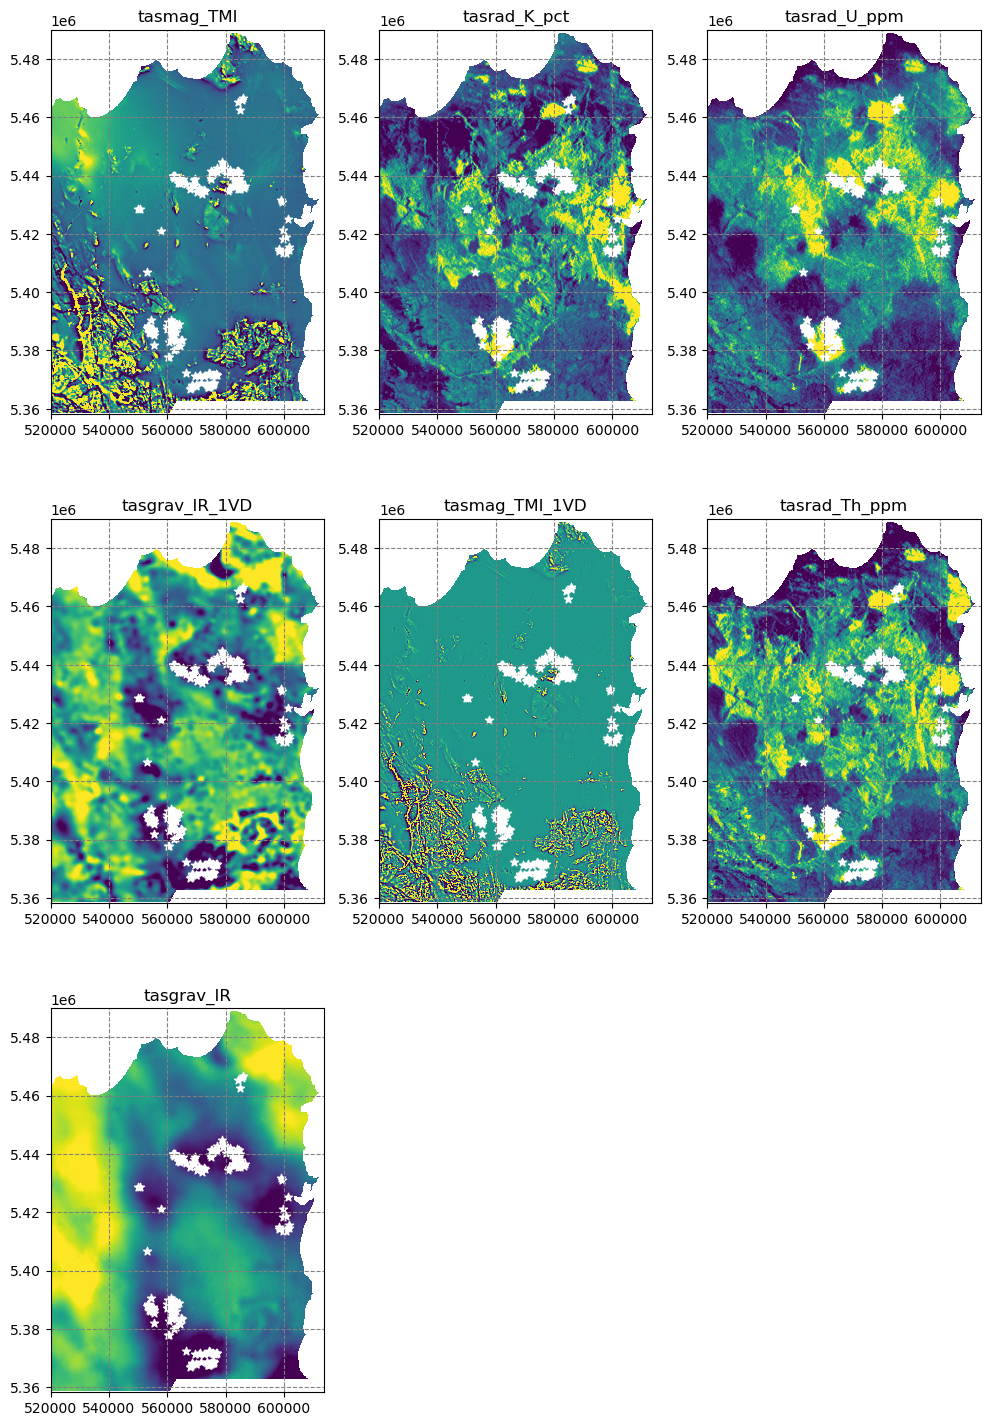

In [9]:
# plot the data
fig, axes = plt.subplots(3,3,figsize=(12,18))
for i, ax in enumerate(axes.flatten()):
    if i < data.shape[0]:
        ax.imshow(data[i], vmin=np.nanpercentile(data[i], 5), vmax=np.nanpercentile(data[i], 95), extent=region)
        ax.set(title=names[i])
        df.plot(ax=ax, marker='*', facecolor='w')
    else:
        ax.axis('off')
plt.show()

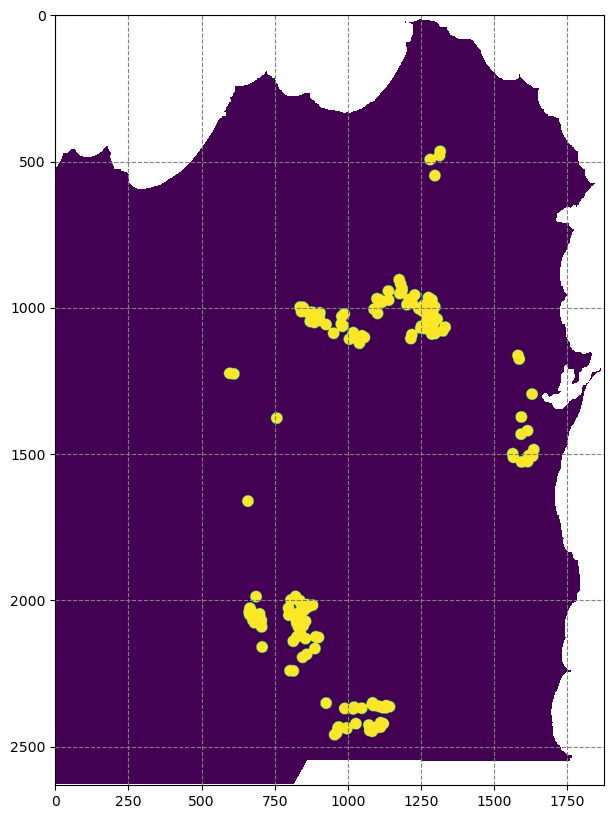

In [10]:
# rasterize the point
geometry_generator = ((geom, 1) for geom in df.buffer(1000).geometry)
labels = rasterize(shapes=geometry_generator, out_shape=data[0].shape, fill=0, transform=transform).astype('float32')
labels[nodata_mask] = np.nan

plt.imshow(labels)

In [11]:
# Check dimensions
if np.shape(labels.flatten())[0] != np.shape(data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T)[0]:
    raise ValueError("Labels and Data shapes (0th dimmension) do not match.")

X_pix = data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T
y_pix = labels.flatten()

# remove nans
X = X_pix[~np.isnan(y_pix)]
y = y_pix[~np.isnan(y_pix)]

print(f"Shape of data after removing NaNs (X): {X.shape}")
print(f"Shape of labels after removing NaNs (y): {y.shape}")

Shape of data after removing NaNs (X): (4002948, 7)
Shape of labels after removing NaNs (y): (4002948,)


## Train Models

In [12]:
cpus = os.cpu_count()
print(f'The number of available CPUs is: {cpus}')

The number of available CPUs is: 8


In this notebook, we will generally use 1 less. I have found that it does not slow it down a ton, but makes the user experiance generally much better. 

### Generate train and testing subsets
We will use the checkerboard example from the previous notebook

In [13]:
# define a function to get probability map
def get_proba_map(X_pix, nodata_mask, model):
    """
    Generates a probability map from input features using a trained model.
    
    Parameters:
    X_pix (np.ndarray): A NumPy array containing the input features for prediction. Each row represents a pixel, and each column represents a feature.
    nodata_mask (np.ndarray): A boolean array with the same shape as the first dimension of X_pix. True values indicate pixels with no data (nodata).
    model (sklearn.base.BaseEstimator): A trained scikit-learn model that supports the predict_proba method.
    feature_names (list of str): A list of feature names corresponding to the columns in X_pix.
    
    Returns:
    np.ndarray: A 2D array with the same shape as nodata_mask, containing the predicted probabilities for each pixel. Pixels with no data are assigned NaN.
    """
    # Remove nulls by filtering out pixels where nodata_mask is True
    X = X_pix[np.invert(nodata_mask.flatten())]
    
    # Get predictions from the model (probability of the positive class)
    predictions = model.predict_proba(X)[:, 1]
    
    # Create an output array initialized to zeros, with the same shape as the flattened nodata_mask
    pred_ar = np.zeros(shape=nodata_mask.flatten().shape, dtype='float32')
    
    # Insert predictions into the output array at positions where nodata_mask is False
    pred_ar[np.invert(nodata_mask.flatten())] = predictions
    
    # Reshape the output array to match the original shape of nodata_mask
    pred_ar = pred_ar.reshape(nodata_mask.shape)
    
    # Assign NaN to positions where nodata_mask is True
    pred_ar[nodata_mask] = np.nan
    
    return pred_ar

### Recap questions:

What are the big differences between the first and second model?

Which one do you like more? 

Any downsides to this methodology?

# How to (try to) overcome spatial autocorrelation

In [14]:
rus = RandomUnderSampler(random_state=32)

In [15]:
def make_checkerboard(board_size: tuple[int, int], square_size: tuple[int, int]) -> np.ndarray:
    """
    Create a checkerboard pattern.

    props to stackoverflow user Blubberguy22, posted March 17, 2020 at 19:00
    https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy

    Parameters:
        board_size (tuple[int, int]): Size of the board in rows and columns.
        square_size (tuple[int, int]): Size of each square in rows and columns.

    Returns:
        np.ndarray: Checkerboard pattern as a NumPy array.
    """
    rows, cols = board_size
    sq_rows, sq_cols = square_size

    # Calculate the checkerboard pattern efficiently
    row_indices = np.arange(rows) // sq_rows
    col_indices = np.arange(cols) // sq_cols
    checkerboard = (row_indices[:, np.newaxis] + col_indices) % 2

    return checkerboard.astype('float32')

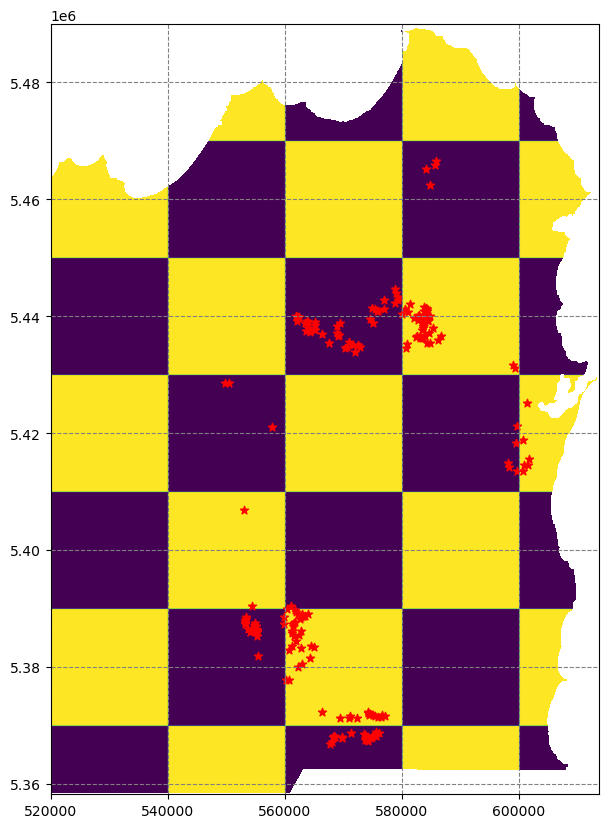

In [16]:
# make checkerboard
checker = make_checkerboard(data[0].shape, (400,400))
checker[nodata_mask] = np.nan

#plot checkerboard
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(checker, extent=region)
df.plot(ax=ax, marker='*', facecolor='r')
plt.show()

In [17]:
# data into checkers
X_check0 = X_pix[checker.flatten()==0]
y_check0 = y_pix[checker.flatten()==0]

X_check1 = X_pix[checker.flatten()==1]
y_check1 = y_pix[checker.flatten()==1]

# remove nans
X_check0 = X_check0[~np.isnan(y_check0)]
y_check0 = y_check0[~np.isnan(y_check0)]

X_check1 = X_check1[~np.isnan(y_check1)]
y_check1 = y_check1[~np.isnan(y_check1)]

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

# run undersampling
X_check0, y_check0 = rus.fit_resample(X_check0, y_check0)
X_check1, y_check1 = rus.fit_resample(X_check1, y_check1)

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

Checker 0: X data array shape is (1949724, 7), y labels array shape is (1949724,)
Checker 1: X data array shape is (2053224, 7), y labels array shape is (2053224,)
Checker 0: X data array shape is (114860, 7), y labels array shape is (114860,)
Checker 1: X data array shape is (106618, 7), y labels array shape is (106618,)


For this project, we will use th checkerboard method from the first notebook. Splitting up the labels would also be valid. 

In [18]:
# fit some models
model0 = XGBClassifier(n_jobs=cpus-1)
model1 = XGBClassifier(n_jobs=cpus-1)

model0.fit(X_check0, y_check0)
model1.fit(X_check1, y_check1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=7,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
# Generate probability maps
pred_ar0 = get_proba_map(X_pix, nodata_mask, model0)
pred_ar1 = get_proba_map(X_pix, nodata_mask, model1)

# Calculate the difference map
difference_map = pred_ar0 - pred_ar1

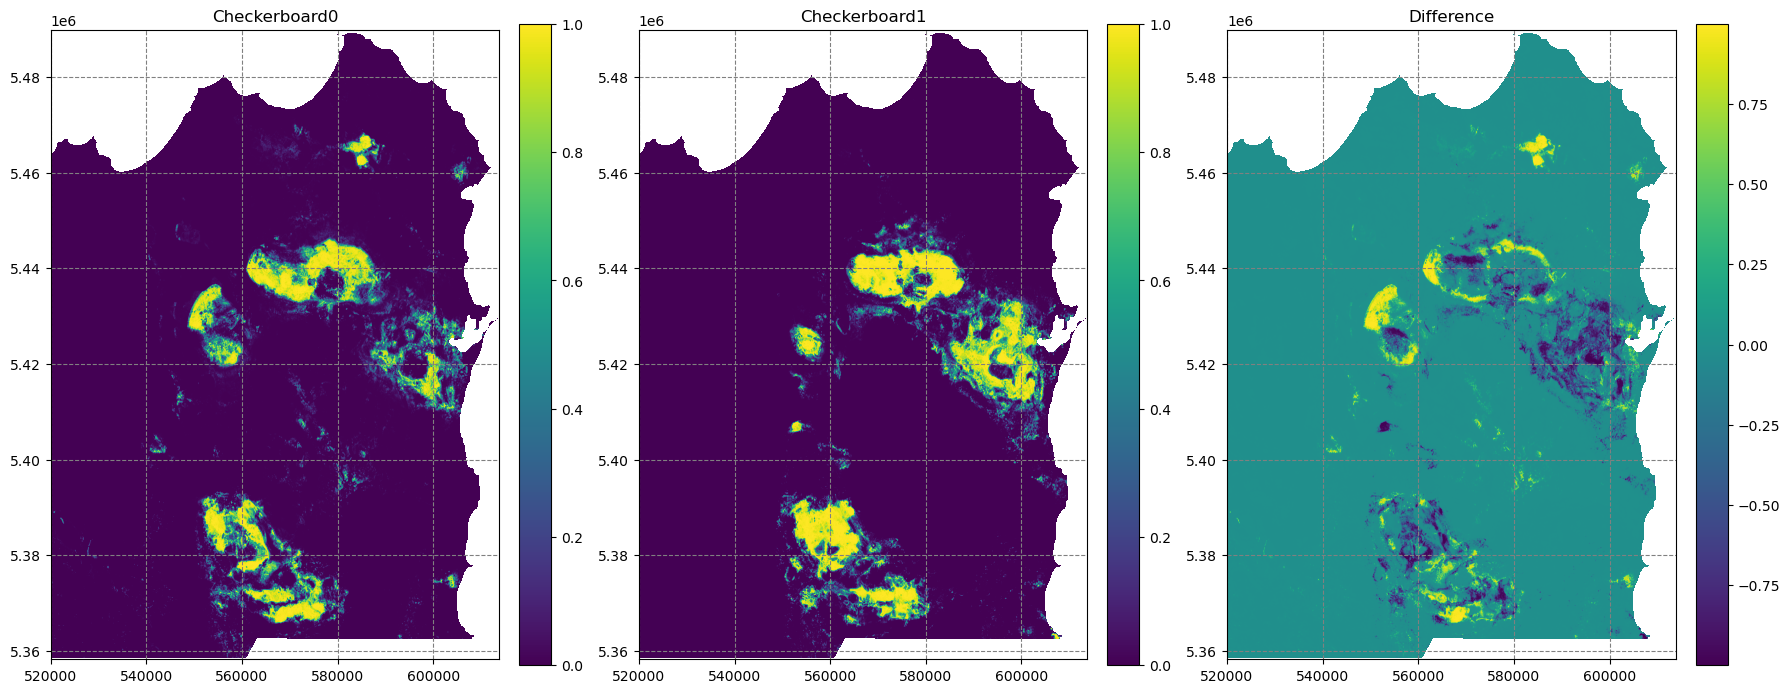

In [20]:
# Plot probability maps
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i, (ar, title) in enumerate(zip([pred_ar0, pred_ar1, difference_map], ['Checkerboard0', 'Checkerboard1', 'Difference'])):
    if title == 'Difference':
        im = ax[i].imshow(ar, extent=region)
    else:
        im = ax[i].imshow(ar, extent=region, vmin=0, vmax=1)
    ax[i].set_title(title)
    # df.plot(ax=ax[i], marker='*', facecolor='w')
    fig.colorbar(im, ax=ax[i], orientation='vertical', fraction=0.064, pad=0.04)

plt.tight_layout()
plt.show()

These results might look a little different than previously due to using XGBoost compared to RandomForest from scikit learn.

## Hyperparmeter Grid Search

Grid search for hyperparameters in machine learning is essential because it systematically explores a range of hyperparameter combinations to find the optimal set that improves model performance. Hyperparameters, such as learning rates, regularization strengths, and kernel parameters, significantly influence the model's learning process and predictive accuracy. A grid search helps ensure that we thoroughly investigate the parameter space, identifying the configuration that maximizes model performance while minimizing overfitting. This method, although computationally intensive, leads to more robust and reliable models by providing a structured approach to optimize their settings for the best possible results.

### What is a hyperparameter?

A hyperparameter is a configuration parameter used in machine learning models that is set before the training process begins and is not learned from the data. Unlike model parameters, which are internal variables learned from the data during training (like weights in a neural network), hyperparameters are external configurations that govern the training process itself and the model's architecture. They play a crucial role in shaping the behavior of the model and its learning capabilities.

#### A quick test, with no parameter tuning:

In [21]:
xgb_clf_test = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf_test.fit(X_check0, y_check0)
preds = xgb_clf_test.predict(X_check1)
accuracy_test = accuracy_score(y_check1, preds)
print(f"Test accuracy: {round(accuracy_test, 2)}")

Test accuracy: 0.8


Notice we are using one checkerboard to score the other. This is different than earlier where we just looked at raw probabilities for the overall map.

#### Let's see if we can improve on that!

In [22]:
# Initialize XGBoost classifier
xgb_clf0 = xgb.XGBClassifier(use_label_encoder=False, 
                             eval_metric='logloss')

We will use this param_grid again, so will not label it 0 or 1.

In [23]:
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.01, 0.5],
    'n_estimators': [25, 50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [24]:
# Set up GridSearchCV
grid_search0 = GridSearchCV(estimator=xgb_clf0, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           verbose=1, 
                           n_jobs=7)

In [25]:
grid_search0.fit(X_check0, y_check0)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=7,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.05, 0.01, 0.5],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [25, 50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [26]:
print(f"Best parameters found: {grid_search0.best_params_}")
print(f"Best cross-validation score: {grid_search0.best_score_}")

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50, 'subsample': 1.0}
Best cross-validation score: 0.8752045969005746


In [27]:
# Evaluate on test set
best_model = grid_search0.best_estimator_
y_pred = best_model.predict(X_check1)
accuracy = accuracy_score(y_check1, y_pred)
print(f"Test accuracy: {round(accuracy, 4)}")

Test accuracy: 0.9104


In [28]:
print('improvement using grid search:', np.round(accuracy - accuracy_test,3))

improvement using grid search: 0.114


#### Now we will do the same thing, but flip-flop the datasets

In [29]:
xgb_clf_test1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf_test1.fit(X_check1, y_check1)
preds = xgb_clf_test1.predict(X_check0)
accuracy_test1 = accuracy_score(y_check0, preds)
print(f"Test accuracy: {round(accuracy_test1, 3)}")

Test accuracy: 0.782


In [30]:
# Initialize XGBoost classifier
xgb_clf1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search1 = GridSearchCV(estimator=xgb_clf0, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           verbose=1, 
                           n_jobs=7)

In [31]:
grid_search1.fit(X_check1, y_check1)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=7,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.05, 0.01, 0.5],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [25, 50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [32]:
print(f"Best parameters found: {grid_search1.best_params_}")
print(f"Best cross-validation score: {grid_search1.best_score_}")

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 25, 'subsample': 0.6}
Best cross-validation score: 0.9084494276134192


In [33]:
# Evaluate on test set
best_model1 = grid_search1.best_estimator_
y_pred1 = best_model1.predict(X_check0)
accuracy1 = accuracy_score(y_check0, y_pred1)
print(f"Test accuracy: {round(accuracy, 3)}")

Test accuracy: 0.91


Few follow up questions:
- Why is using the other checkerboard a good test?
- How different are the various hyperparameters from the two searches?
- Did the improvment suprise you from standard hyperparameters to best ones?

## Recursive Feature Elimination and Feature Importance

In [34]:
X_train = pd.DataFrame(X_check0, columns=names)
X_test = pd.DataFrame(X_check1, columns=names)

y_train = pd.DataFrame(y_check0)
y_test = pd.DataFrame(y_check1)

In [35]:
model.fit(X_train, y_train)

# Get feature importances and sort them
feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [X_train.columns[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display largest importance at the top
plt.show()

NameError: name 'model' is not defined

In [ ]:
# Create an XGBoost classifier
model = XGBClassifier(max_depth=3, 
                      n_estimators=50,
                      learning_rate=0.01)

# Create an RFE object
rfe = RFE(estimator=model)

# Fit the RFE object to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = rfe.get_support(indices=True)

# Train a new XGBoost classifier on the selected features
model = XGBClassifier()
model.fit(X_train.iloc[:, selected_features], y_train)

# Evaluate the model on the testing set
y_pred = model.predict(X_test.iloc[:, selected_features])
accuracy = accuracy_score(y_test, y_pred)

# Calculate the accuracy for different number of features
n_features = range(1, X_train.shape[1] + 1)
accuracies = []
for n in n_features:
    selected_features = rfe.get_support(indices=True)[:n]
    model = XGBClassifier()
    model.fit(X_train.iloc[:, selected_features], y_train)
    y_pred = model.predict(X_test.iloc[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)


In [ ]:
# Plot the accuracy vs. number of features
plt.figure(figsize=(6, 4))
plt.plot(n_features, accuracies)
plt.scatter(n_features, accuracies, alpha=0.4)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of features for XGBoost classification with RFE')

# Set the x axis to every data point
plt.xticks(n_features)

# Flip the x-axis
#plt.gca().invert_yaxis()

plt.show()